In [141]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
warnings.filterwarnings('ignore')

## 1. K-Means

In [207]:
class KMeansClustering:
    def __init__ (self, n_iters, tol=1e-3, max_k=6):
        self.n_iters = n_iters #number of random initializations
        self.tol = tol #tolerance for stopping criteria
        self.max_k = max_k #maximum k value to be checked for elbow test
        
    def initialize_centers(self, X, k):
        centers = [] #list to store all initial cluster centers
        
        i = np.random.randint(len(X)) #first point is picked at random
        centers.append(X[i,:]) #append first point in the list
        
        while len(centers) < k: #iterate till we have K cluster centers

            farthest_dist = -np.inf #initialize it with large negative number
            farthest_pt = None #to track the index of farthest point

            for idx,x in enumerate(X): #iterate over each observation
                c_dist = [] #list to store the distance of each observation from cluster centers

                for c in centers: #iterate over each center
                    c_dist.append(euclidean(c,x)**2) #calculate distance of the centers from the point and append in list

                #once we have distances from all the centers we need to sum them up
                added_dist = np.sum(c_dist)

                #to check if the point is farthest as compared to rest of the points
                if added_dist > farthest_dist:
                    farthest_dist = added_dist #to track the distance itself
                    farthest_pt = idx #to track the index

            #add the farthest point as new cluster center       
            centers.append(X[farthest_pt,:])
            
        return centers
            
    def find_associations(self, X, centers):
        associations = [] #list to store association of each point with the clusters
        for x in X: #iterate over each example
            c_dist = [] #list to store distance of point from each cluster center
            for c in centers: #iterate over each cluster center
                c_dist.append(euclidean(c,x)**2) #calculate distance of the centers from the point and append in list
            #once we have distances from all the centers we need to find the minimum one and append in list
            associations.append(np.argmin(c_dist))
        return associations
            
    def compute_cluster_center(self, X, associations, k):
        cls = np.arange(k) #number of clusters
        centers = [] #list to store the new cluster centers
        for cl in cls: #iterate for each class 
            idx = np.array(associations) == cl #find the index of all instances which belong to particular cluster
            centers.append(X[idx,:].mean(axis=0)) #to find the mean of all the instances, this will be the new cluster center
        return centers
                
    def check_stop(self, old, new, k):
        d = 0 #to store the sum of differences between the old and new means
        for ki in range(k): #for all the clusters
            #check the euclidean distance between the old and new means and add them for each cluster
            d += euclidean(old[ki],new[ki])
        return d/k
    
    def calculate_distortions(self, X, associations, centers):
        distortion = 0 #to track the distortion of the model
        for i,c in enumerate(centers): #first calculate the distortion of each example from its respective cluster
            idx = np.array(associations) == i #find the index of all instances which belong to particular cluster
            X_subset = X[idx] #find the subset of data
            c_distortion = 0 #to track distortion within each cluster
            for x in X_subset: #iterate over the subset of data
                c_distortion += euclidean(centers[i],x)**2 #find the distance of each point from its center
            #once we have cluster wise distortion, add them up
            distortion += c_distortion
        return distortion   
    
    def find_optimal_k(self, X, centers):
        distort_lst = [] #list to store distortion for each value of k
        centers_lst = [] #to store the centers
        for k in range(1, self.max_k + 1): #iterate over all ks
            #fit the Kmeans for each k
            c = self.fit_once(X, centers, k)
            
            centers_lst.append(c)
            #now find the distortion
            P = self.find_associations(X, c)
            distort = self.calculate_distortions(X, P, c)
            
            #store the value of distortion for current value of k
            distort_lst.append(distort)

        diff = np.diff(distort_lst) #to find difference of each distortion
        diff_r = diff[1:] / diff[:-1] #take the ratio
        optimal_k = np.argmax(diff_r) + 1 #find the most drastic change
        best_centers = centers_lst[optimal_k] #get the center associated with optimal k
        return optimal_k, distort_lst, best_centers
    
    def plot_elbow(self, X, centers, init_count):
        best_k, d_list, _ = self.find_optimal_k(X, centers) #find the best number of clusters
        plt.plot(np.arange(1, self.max_k +1),d_list) #plot the num cluster against distortion
        #highlight best number of cluster
        plt.plot(best_k,d_list[best_k-1], marker="o", markersize=10, markerfacecolor="red",label='Best Cluster')
        #formatiing the plot
        plt.title(f'Best Number of Cluster for initialization {init_count}')
        plt.xlabel('Number of clusters')
        plt.legend()
        plt.ylabel('Distortion')
        plt.show()

    def fit_once(self, X, centers, k):
        while True: #this keeps the loop running until the stopping criteria has been met
            if self.elbow_plot == True:
                centers = centers[:k]
            #to find the association of each observation with cluster
            P = self.find_associations(X,centers)
            #to find the means of our clusters
            new_centers = self.compute_cluster_center(X, P, k)
            #to avoid cluster with 0 elements
            empty_cls= len(np.unique(P)) == k #check if we have empty cluster
            #if we catch an empty cluster
            if not empty_cls is True:
                #to find which cluster has zero members
                ec = [k for k in np.arange(k) if not k in np.unique(P)]
                #iterte over all such empty clusters
                for e in ec:
                    new_centers[e] = centers[e] #do not change their cluster mean

            #to check the stopping criteria
            err = self.check_stop(centers, new_centers, k)
            #replace old centers with new ones for next iteration
            centers = new_centers
            #stop the process once the value is lower than tolerance
            if err < self.tol:
                self.optimial_centers = new_centers #store the optimal centers
                return self.optimial_centers
    
    def fit(self, X, k, plot_elbow=False):
        low_distort = np.inf #store the smallest distortion
        self.elbow_plot = plot_elbow
        for i in range(1,self.n_iters+1): #do random initialization bunch of times
            centers = self.initialize_centers(X, self.max_k) #this initializes all the centers at once
            #to check if we do not want to plot best number of cluster for each initialization
            if plot_elbow is False:
                centers = centers[:k] #only obtain first k clusters
                oc = self.fit_once(X, centers, k) #fitting the model
            else:
                self.plot_elbow(X, centers, i) #this prints the plot of cluster for each initialization
            #now it's time to find the distortion of our optimal model
            P = self.find_associations(X,self.optimial_centers)
            distort = self.calculate_distortions(X, P, self.optimial_centers)
            #check if the distortion is minimal
            if distort < low_distort:
                low_distort = distort #replace the lowest with current distortion
                self.distort = distort
                self.centers = self.optimial_centers #store the optimal centers in class variable
                
                
    def predict(self, X):
        return self.find_associations(X,self.centers) #it is analogus to step of finding the association

In [208]:
df = pd.read_csv('HTRU_2.csv')

Since the feature are not standardized we need to standardize them as all distance metric based algorithms are sensitive to scale.

In [209]:
X = StandardScaler().fit_transform(df)

Here our algorithm is capable of selecting first center as random and then rest with the maximum distance from cluster centers sequentially. Also we will run our algorithm for 10 random initializations.

In [210]:
KMClustering = KMeansClustering(n_iters=10)

Now let's fit the model

In [146]:
in_time = time.time()
KMClustering.fit(X, k=3)
print('The time taken by our implementation is',time.time()-in_time)

The time taken by our implementation is 344.9326207637787


To find the centers found by our model and its distortion.

In [19]:
KMClustering.centers

[array([ 0.19366852,  0.67647291, -0.12640023, -0.18294493,  1.86305249,
         2.22901961, -1.59808246, -0.96613068]),
 array([-2.89344132, -1.78440892,  3.65370604,  3.58490837,  1.72069603,
         1.85988277, -1.48825748, -0.94368237]),
 array([ 0.16608832,  0.03984713, -0.22300311, -0.21218408, -0.32101695,
        -0.37116818,  0.27615832,  0.16980633])]

In [27]:
print('The Distortion of our implementation is',KMClustering.distort)

The Distortion of our implementation is 68071.97894325407


Let's compare it from the Sklearn's implementation

In [23]:
kmeans = KMeans(n_clusters=3,n_init=10)

In [24]:
init_time = time.time()
kmeans.fit(X)
print('The time taken by Sklearn Implementation is', time.time()-init_time)

The time taken by Sklearn Implementation is 0.7810816764831543


To find cluster centers and distortion of sklearn implementation

In [25]:
kmeans.cluster_centers_

array([[ 0.16608832,  0.03984713, -0.22300311, -0.21218408, -0.32101695,
        -0.37116818,  0.27615832,  0.16980633],
       [-2.89344132, -1.78440892,  3.65370604,  3.58490837,  1.72069603,
         1.85988277, -1.48825748, -0.94368237],
       [ 0.19366852,  0.67647291, -0.12640023, -0.18294493,  1.86305249,
         2.22901961, -1.59808246, -0.96613068]])

In [29]:
print('The Distortion of Sklearn implementation is',kmeans.inertia_)

The Distortion of Sklearn implementation is 68071.97894325387


**Conclusion:** Here we can see that the cluster centers found by the Sklearn is exactly same as what we found, also the distortion value is also same.

Now let's plot a figure showing the selection of the best number of clusters K for each initialization

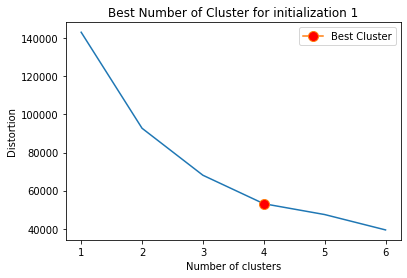

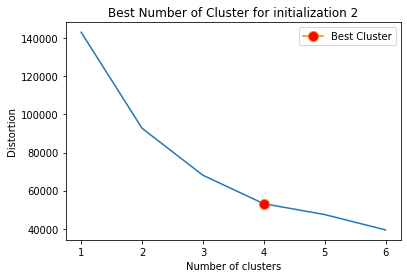

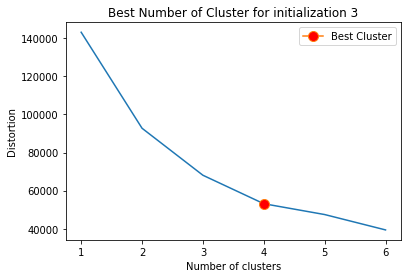

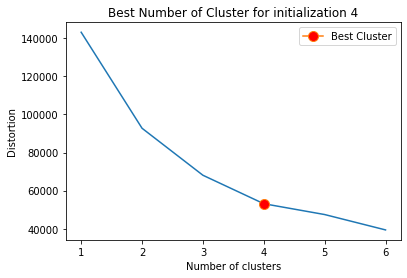

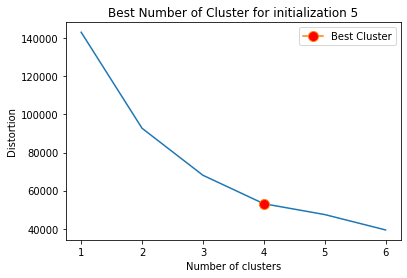

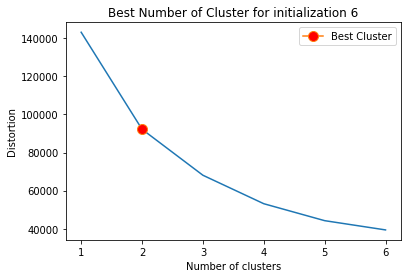

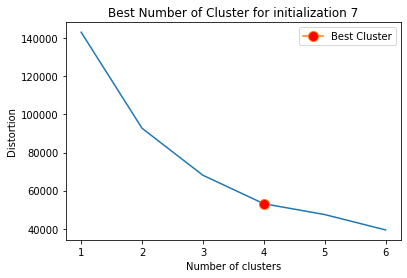

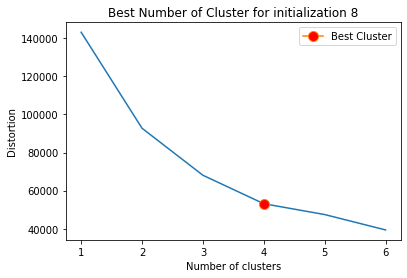

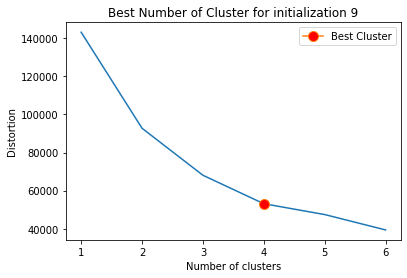

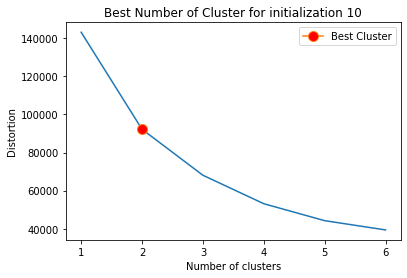

In [211]:
KMClustering.fit(X,k=None,plot_elbow=True) #however here the given K doesnot matter as we will plot for various number of cluster

## PCA

In [131]:
class DimensionalityReduction:
    def __init__ (self, n_components):
        self.n_components = n_components #the number of dimensions we want to represent our data
        
    def transform(self, X, mode):
        #first perform mean centering of the data
        X_centered = X - np.mean(X , axis = 0)
        
        #using SVD method
        if mode == 'svd':
            u,s,v = np.linalg.svd(X_centered) #perform the singular value decomposition
            m,n = X.shape #to find the dimensions of our data
            #to create a matrix of singular values of same dimensions as that of X
            S = np.zeros(X_centered.shape)
            S[:n,:n] = np.diag(s) #enter the sigular values on diagonal
            S_reduced = S[:,:self.n_components] #only take the singular values till the dimension we want to reduce
            X_reduced = np.matmul(u,S_reduced) #reduce the dimensions
        
        #using PCA method
        elif mode == 'pca':
            #find the covariance matric of same dimension
            cov_matrix = np.cov(X_centered , rowvar = False)
            #to get the eigen values and eigen vectos of covariance matrix
            eigh_vals , eigh_vecs = np.linalg.eigh(cov_matrix)
            #sort by maximum to minimum eigen value
            sorted_idx = np.argsort(eigh_vals)[::-1] #argsort sort ascendingly we want in descending fashion therefore inverting
            sorted_eighvals = eigh_vals[sorted_idx] #from index get the values themselves
            sorted_eighvecs = eigh_vecs[:,sorted_idx] #from index get the vector themselves
            #reduce the eigenvector
            reduced_eighvecs = sorted_eighvecs[:,:self.n_components]
            #performing PCA
            X_reduced = (reduced_eighvecs.T @ X_centered.T).T
        
        return X_reduced

Let's reduce the dimension of our data to 2-d

In [132]:
pca_analysis = DimensionalityReduction(n_components=2)

In [133]:
X_red = pca_analysis.transform(X,'pca')

Now, let's compare our result from sklearn's implementation

In [90]:
pca_sklearn = PCA(n_components=2).fit_transform(X)

One thing to notice here is that the only differnce between our reduced representation and sklearn's is that in our case the axis are rotated, however the values are same. We can verify that by rotating our axis too.

In [91]:
#to rotate the axis of our data
X_red[:,1] = X_red[:,1]*-1

np.allclose(X_red, pca_sklearn)

True

**Conclusion:** The numpy in-built function which compares two arrays returns True which means that the reduced representation in our's and sklearn's case is same.

Let's perform the clustering and plot clusters. Since we have already seen that ours and sklearn's implementation give same results and distortion values, we will use sklearn's implementation as it is fast

In [77]:
km = KMeans(n_clusters=3)
km.fit(X_red)
labels = km.predict(X_red)

Now it is time to plot the clusters

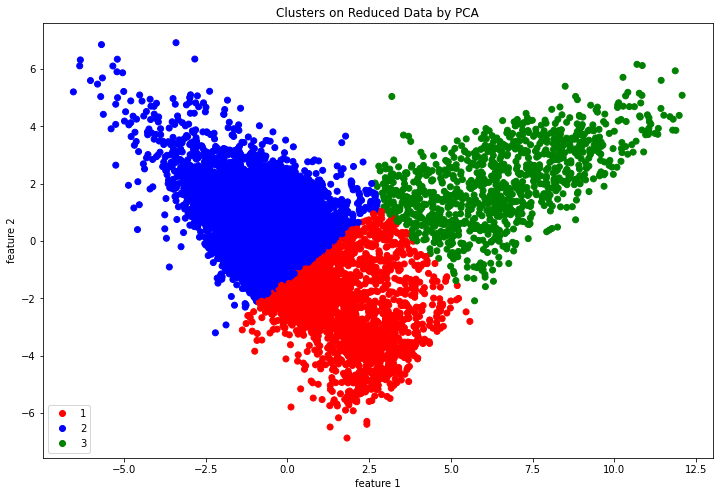

In [86]:
plt.figure(figsize=(12,8))
classes = ['1', '2', '3']
colors = ListedColormap(['r','b','g'])
scatter = plt.scatter(X_red[:,0],X_red[:,1],c=labels, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes);
plt.title('Clusters on Reduced Data by PCA');
plt.xlabel('feature 1');
plt.ylabel('feature 2');

## 2. Gaussian Mixtures

In [126]:
class GMModel:
    def __init__ (self, tol=0.09, mode='soft', max_iter=30):
        self.tol = tol #tolerance to break out of loop
        self.mode = mode #to determine whether to perform soft or hard clustering
        self.max_iter = max_iter
        
    def fit(self, X, num_components):
        #to get the features and observations from the data
        num_obs,m = X.shape
        #to store num_components in class variable
        self.nc = num_components

        #initially the qn are sampled from a uniform normal distribution
        qn_ = np.random.uniform(size=(num_obs,num_components)) #the size will be n x k
        
        #to get weights per example between 0 and 1 we will normalize
        if self.mode == 'soft':
            qn = qn_/qn_.sum(axis=1).reshape(-1,1)
        
        #for hard clustering we will assign points to the cluster with the highest responsibility
        else:
            qn  = np.zeros(shape=(num_obs,num_components))
            qn[np.arange(num_obs),np.argmax(qn_,axis=1)] = 1
        
        #now we will keep iterating until the loop breaks itself
        for _ in range(self.max_iter):
            
            #initializing the model parameters
            pi_k = None
            meu_k = np.zeros(shape=(m,num_components))
            sigma_k = np.zeros(shape=(num_components,m,m))
            
            #### Maximization Step #####
            for k in range(num_components): #iterate over all the clusters
                #first we need to find the value of pi_k
                pi_k = qn.sum(axis=0)/num_obs
                
                #then we need means of the distribution (we will vectorize this operation for efficiency)
                meu_k[:,k] = ((X.T @ qn[:,k].reshape(-1,1))/np.sum(qn[:,k])).reshape(-1)
                
                #finally we need to calculate the variance of the distribution
                add = np.zeros(shape=(m,m))
                
                #iterate over all observations
                for n,x in enumerate(X):
                    x = x.reshape(-1,1)
                    add += (qn[n,k]* (x@x.T)) #this calculate the numerator
                
                #to calculate the variance of the gaussians
                sigma_k[k] = add/np.sum(qn[:,k]) - meu_k[:,[k]]@meu_k[:,[k]].T
                
            #### Expectation Step #####
            qn_ = np.zeros(shape=(num_obs,num_components)) #initialize the empty cluster
            for k in range(num_components): #to iterate over all clusters
                for n,x in enumerate(X): #iterate over each observation
                    
                    #calculate the probability of the sample belonging to particular gaussian
                    dist = multivariate_normal(meu_k[:,k],sigma_k[k],allow_singular=True)
                    qn_[n,k] = dist.pdf(x)
                      
            #for soft clustering we will not only focus on the maximum probability
            if self.mode == 'soft':
                qn_new = qn_/qn_.sum(axis=1).reshape(-1,1)
            
            #for hard clustering we will assign points to the cluster with the highest responsibility
            else:
                qn_new  = np.zeros(shape=(num_obs,num_components))
                qn_new[np.arange(num_obs),np.argmax(qn_,axis=1)] = 1
                
            #stopping criteria
            if np.linalg.norm(qn_new - qn) < self.tol:
                break
            
            #replace the old q with new one for next iteration
            qn = qn_new
        
        #store the model parameters in class variable
        self.meu_k = meu_k
        self.sigma_k = sigma_k
        self.pi_k = pi_k
        self.q = qn_new

    def calculate_distortion(self, X, k, qn, means, covariances):
        #the negative log-likelihood is considered as distortion in case of Gaussian Mixture
        nll = 0
        num_obs, m = X.shape #get the shape of data
        
        for i in range(num_obs): #iterate over each example
            log_likelihood = 0 #to accumulate the log-likelihood
            
            for j in range(k): #iterate over each cluster/gaussian
                #calculate the probability of belonging to particular gaussian
                log_likelihood += qn[i,j] * multivariate_normal.pdf(X[i,:], mean=means[:,j], cov=covariances[j], allow_singular=True)
            
            #get the neg-log-likelihood
            nll -= np.log(log_likelihood)
        return nll / num_obs
    
    def plot_elbow(self, X, max_k=6):
        distort_lst = [] #to store distortion at each number of cluster
        for k in range(1,max_k+1): #iterate over multiple value of K
            self.fit(X,k) #train the model
            
            #get the distortion of the model
            distort_lst.append(self.calculate_distortion(X,k,self.q,self.meu_k,self.sigma_k))
        
        #plotting the plot of K vs distortion
        plt.plot(np.arange(1, max_k +1),distort_lst) #plot the num cluster against distortion
        plt.title('Best Number of Cluster for initialization')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion')
        plt.show()        
        
    
    def predict(self, X):
        num_obs, m = X.shape #to get the shape of data
        qn_ = np.zeros(shape=(num_obs,self.nc)) #initialize the empty array
        
        for k in range(self.nc): #iterate over each cluster
            for n,x in enumerate(X): #iterate over each observation
                dist = multivariate_normal(self.meu_k[:,k],self.sigma_k[k], allow_singular=True)
                qn_[n,k] = dist.pdf(x)
        
        #normalize it
        qn_new = qn_/qn_.sum(axis=1).reshape(-1,1)
        return qn_new

Now it is time to train the model. We will train it using n_components=3

In [127]:
gmm = GMModel(mode='soft')
gmm.fit(X,num_components=3)

In [128]:
preds = np.argmax(gmm.predict(X),axis=1)

array([[1.64580470e-052, 9.98577242e-001, 1.42275761e-003],
       [1.53785528e-216, 9.97297130e-001, 2.70287031e-003],
       [1.00544209e-029, 9.99865498e-001, 1.34502260e-004],
       ...,
       [1.00000000e+000, 0.00000000e+000, 1.33306094e-296],
       [1.49436334e-277, 8.20415013e-001, 1.79584987e-001],
       [1.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

Plot, a figure showing the selection of the best number of clusters K

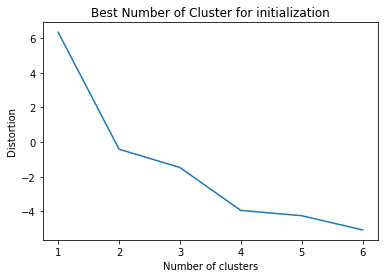

In [139]:
gmm = GMModel()
gmm.plot_elbow(X)

We can infer num_components equals 3 as a good value for number of clusters

Plot the optimal cluster by assigning points to the cluster with the highest responsibility (Hard Clustering)
using PCA.

In [ ]:
Gmm = GMModel(mode='hard')
Gmm.fit(X_red,num_components=3)

In [136]:
preds = np.argmax(Gmm.predict(X_red),axis=1)

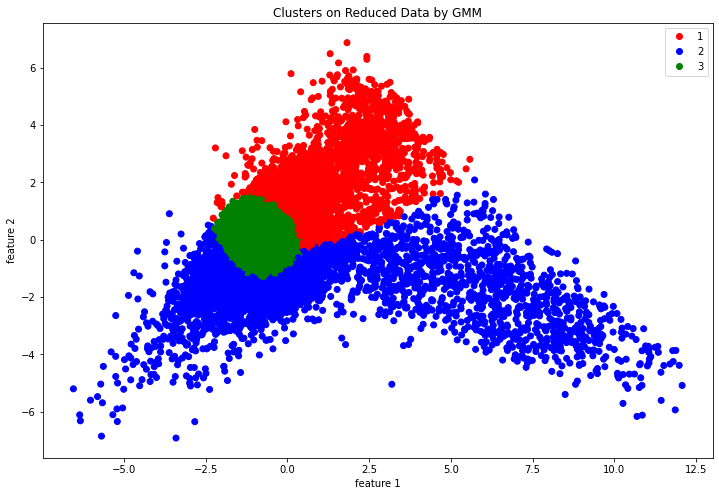

In [138]:
plt.figure(figsize=(12,8))
classes = ['1', '2', '3']
colors = ListedColormap(['r','b','g'])
scatter = plt.scatter(X_red[:,0],X_red[:,1],c=preds, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes);
plt.title('Clusters on Reduced Data by GMM');
plt.xlabel('feature 1');
plt.ylabel('feature 2');

References:
1. https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
2. https://stackoverflow.com/questions/17411940/matplotlib-scatter-plot-legend